# **Initialisation**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

#Import Walmart CSV Dataset 
data = pd.read_csv("/kaggle/input/walmart-dataset/Walmart.csv")

# **Data Collection and Exploration**

In [2]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
print("Numerical Features:")
print(numerical_columns)

categorical_columns = data.select_dtypes(include=['object']).columns
print("\nCategorical Features:")
print(categorical_columns)

Numerical Features:
Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

Categorical Features:
Index(['Date'], dtype='object')


In [5]:
def seasonName(quarter):
    if quarter == 1: return 'Winter'
    elif quarter == 2: return 'Spring'
    elif quarter == 3: return 'Summer'
    else: return 'Autumn'
    
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y")
data['Week'] = data['Date'].dt.isocalendar().week.astype('int32')
data['Month_Name'] = data['Date'].dt.month_name()
data['Quarter'] = data['Date'].dt.quarter
data['Season'] = data['Quarter'].map(seasonName)

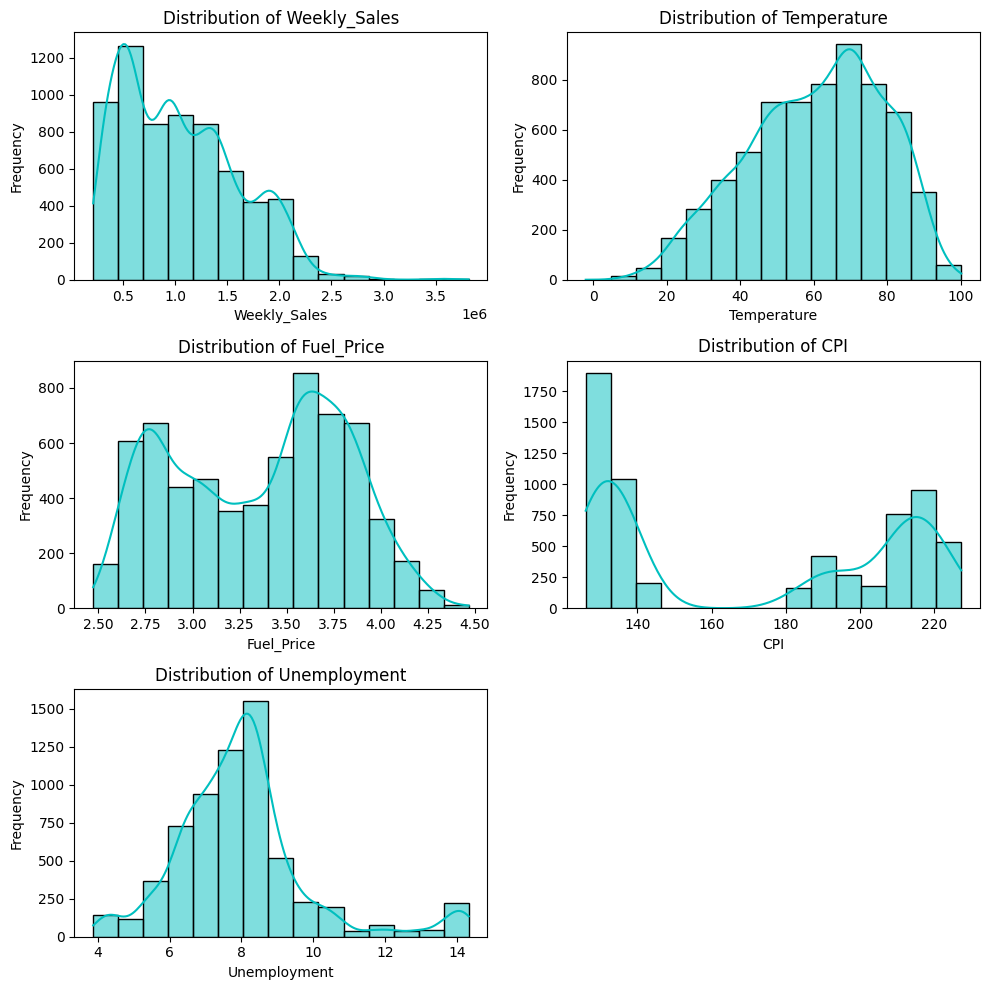

In [6]:
numerical_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

plt.figure(figsize=(10, 10))

for col in numerical_columns:
    plt.subplot(3, 2, numerical_columns.index(col) + 1)
    sns.histplot(data=data, x=col, kde=True, bins=15, color='c')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

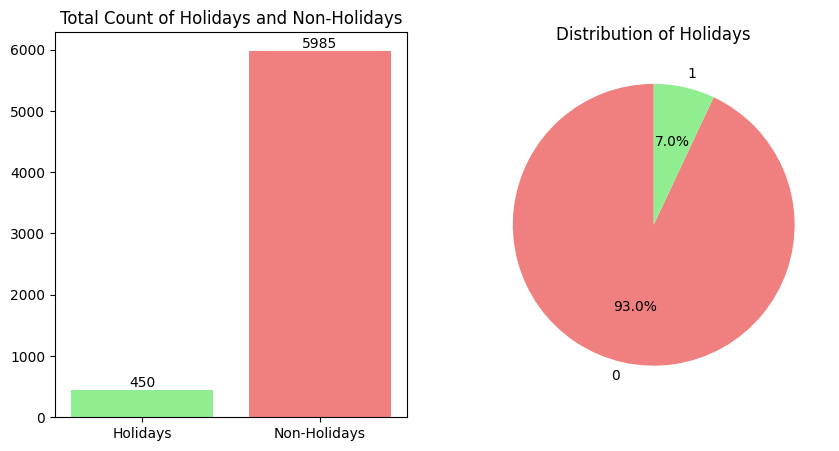

In [7]:
holiday_counts = data['Holiday_Flag'].value_counts()

total_holidays = holiday_counts.get(1, 0)
total_non_holidays = holiday_counts.get(0, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(['Holidays', 'Non-Holidays'], [total_holidays, total_non_holidays], color=['lightgreen', 'lightcoral'])
plt.title('Total Count of Holidays and Non-Holidays')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha = 'center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title('Distribution of Holidays')

plt.show()

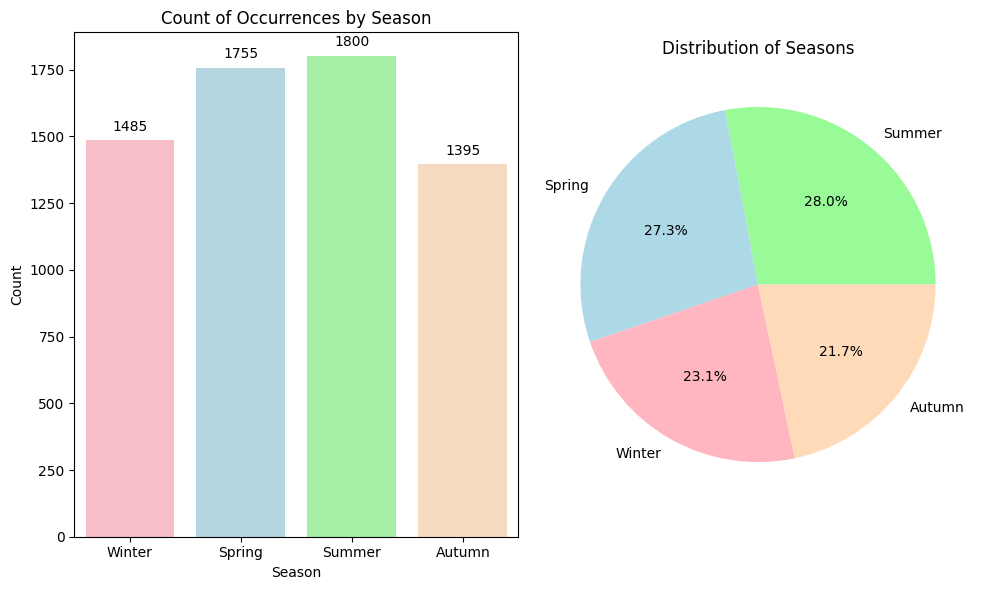

In [8]:
season_counts = data['Season'].value_counts()

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
ax = sns.countplot(data = data, x = 'Season', order = season_order, palette = ['#FFB6C1', '#ADD8E6', '#98FB98', '#FFDAB9'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Count of Occurrences by Season')

plt.subplot(1, 2, 2)
plt.pie(season_counts, labels = season_counts.index, autopct = '%1.1f%%', colors = ['#98FB98', '#ADD8E6', '#FFB6C1', '#FFDAB9'])
plt.title('Distribution of Seasons')

plt.tight_layout()
plt.show()

# **Data Preprocessing**

In [9]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Week            0
Month_Name      0
Quarter         0
Season          0
dtype: int64

In [10]:
data.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Week                     int32
Month_Name              object
Quarter                  int32
Season                  object
dtype: object

In [11]:
data_preprocess = data.copy()
data_preprocess.drop(['Date', 'Quarter'], axis = 1, inplace = True)

data_preprocess.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week              int32
Month_Name       object
Season           object
dtype: object

In [12]:
data_preprocess['Store'] = data_preprocess['Store'].astype('object')
data_preprocess['Holiday_Flag'] = data_preprocess['Holiday_Flag'].astype('object')
data_preprocess['Week'] = data_preprocess['Week'].astype('object')

data_preprocess.dtypes

Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week             object
Month_Name       object
Season           object
dtype: object

In [13]:
X = data_preprocess.drop('Weekly_Sales', axis = 1)
y = data_preprocess['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

num_feats = data_preprocess.select_dtypes('number').columns.to_list()
num_feats.remove('Weekly_Sales')

cat_feats = data_preprocess.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_feats}')
print(f'Categorical Features: {cat_feats}')

Numerical Features : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Categorical Features: ['Store', 'Holiday_Flag', 'Week', 'Month_Name', 'Season']


In [14]:
preprocessor = ColumnTransformer([('num_features', StandardScaler(), num_feats),
                                  ('cat_features', BinaryEncoder(), cat_feats),])

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# **Model Building and Evaluation**

In [15]:
#Calculating the evaluation metrics of the decision tree
def evaluateModel(model, X, y_test):
    
    y_predict = model.predict(X)
    
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test, y_predict)

    print(f"Mean Absolute Error: {MAE}")
    print(f"Mean Squared Error: {MSE}")
    print(f"Root Mean Squared Error: {RMSE}")
    print(f"\nR2 Score: {R2}")

## **1. Decision Tree Regressor** 

In [16]:
decisionTree_regressor = DecisionTreeRegressor()
decisionTree_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for Decision Tree Regressor Model\n")
evaluateModel(decisionTree_regressor, X_train_transformed, y_train)


Evaluation for Decision Tree Regressor Model

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0

R2 Score: 1.0


## **2. Linear Regression** 

In [17]:
linearRegression_regressor = LinearRegression()
linearRegression_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for Linear Regression Model\n")
evaluateModel(linearRegression_regressor, X_train_transformed, y_train)


Evaluation for Linear Regression Model

Mean Absolute Error: 445396.7314952883
Mean Squared Error: 282687248083.4086
Root Mean Squared Error: 531683.4096371718

R2 Score: 0.10969474712530514


## **3. K-Nearest Neighbors Regressor** 

In [18]:
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train_transformed, y_train)

print("\nEvaluation for K-Nearest Neighbors Regressor Model\n")
evaluateModel(knn_regressor, X_train_transformed, y_train)


Evaluation for K-Nearest Neighbors Regressor Model

Mean Absolute Error: 280699.1654696969
Mean Squared Error: 134593881455.65982
Root Mean Squared Error: 366870.38781517895

R2 Score: 0.576105252439928


# **Hyperparameter Tuning**

In [19]:
#Tuning the model to optimise the performance
def tuneModel(estimator, X_train, y_train, param_grid, cv=5):   
    
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                               scoring='r2',
                               cv=cv)

    # Fit the data
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params} \n")
    print(f"Best R2 score: {best_score}")
    
    best_estimator = grid_search.best_estimator_
    return best_estimator

## **1. Decision Tree Regressor** 

In [20]:
dt_param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

decisionTree_regressor_tuned = tuneModel(decisionTree_regressor, X_train_transformed, y_train, dt_param_grid, cv = 5)

Best parameters: {'max_depth': 14, 'min_samples_split': 30} 

Best R2 score: 0.920540174754574


In [21]:
print("\nEvaluation for tuned Decision Tree Regressor Model\n")
evaluateModel(decisionTree_regressor_tuned, X_train_transformed, y_train)


Evaluation for tuned Decision Tree Regressor Model

Mean Absolute Error: 60982.86422979938
Mean Squared Error: 12702400153.36086
Root Mean Squared Error: 112704.92515130322

R2 Score: 0.959994610095335


In [22]:
print("\nTesting the tuned Decision Tree Regressor Model\n")
evaluateModel(decisionTree_regressor_tuned, X_test_transformed, y_test)


Testing the tuned Decision Tree Regressor Model

Mean Absolute Error: 85878.88708381046
Mean Squared Error: 25723073383.132168
Root Mean Squared Error: 160384.14317859535

R2 Score: 0.920153006640221


## **2. Linear Regression** 

In [23]:
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

param_grid = {'poly_feat__degree': [2, 3, 4]}

linearRegression_regressor_tuned = tuneModel(LR_pipe, X_train_transformed, y_train, param_grid, cv = 5)

Best parameters: {'poly_feat__degree': 3} 

Best R2 score: 0.9596253351731072


In [24]:
print("\nEvaluation for tuned Linear Regression Model\n")
evaluateModel(linearRegression_regressor_tuned, X_train_transformed, y_train)


Evaluation for tuned Linear Regression Model

Mean Absolute Error: 50013.53652680652
Mean Squared Error: 5346534842.949173
Root Mean Squared Error: 73120.00302891934

R2 Score: 0.9831614333945805


In [25]:
print("\nTesting the tuned Linear Regression Model\n")
evaluateModel(linearRegression_regressor_tuned, X_test_transformed, y_test)


Testing the tuned Linear Regression Model

Mean Absolute Error: 73390.14815073814
Mean Squared Error: 11561618359.577126
Root Mean Squared Error: 107524.96621518709

R2 Score: 0.9641115798786776


## **3. K-Nearest Neighbors Regressor** 

In [26]:
knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13]}

knn_regressor_tuned = tuneModel(knn_regressor, X_train_transformed, y_train, knn_param_grid, cv = 5)

Best parameters: {'n_neighbors': 13} 

Best R2 score: 0.3530567607408912


In [27]:
print("\nEvaluation for tuned KNN Regressor Model\n")
evaluateModel(knn_regressor_tuned, X_train_transformed, y_train)


Evaluation for tuned KNN Regressor Model

Mean Absolute Error: 334245.1421195684
Mean Squared Error: 170681912401.75092
Root Mean Squared Error: 413136.67520779476

R2 Score: 0.46244832686212667


In [28]:
print("\nTesting the tuned KNN Regressor Model\n")
evaluateModel(knn_regressor_tuned, X_test_transformed, y_test)


Testing the tuned KNN Regressor Model

Mean Absolute Error: 372400.97612814535
Mean Squared Error: 209049193400.26334
Root Mean Squared Error: 457218.9775154388

R2 Score: 0.3510903884353235
